In [1]:
#Import Packages

from bs4 import BeautifulSoup as BS
import urllib.request
import pandas as pd

import pandas as pd
import numpy as np
import geopandas as gpd
import shapely.geometry
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

In [2]:
#Read in GeoJSONs with Geopandas

plates_gdf = gpd.read_file("MR_Data/PB2002_plates.json")
countries_gdf = gpd.read_file("MR_Data/countries.geojson")
earthquakes_gdf = gpd.read_file("MR_Data/earthquakes.GeoJSON")
volcanoes_gdf = gpd.read_file("MR_Data/volcanoes.GeoJSON")
vents_gdf = gpd.read_file("MR_Data/vents.GeoJSON")

fig, ax = plt.subplots(figsize = (20, 20))
ax.set_aspect('equal')
plates_gdf.plot(ax=ax, color='blue', edgecolor='white', alpha = 0.3, lw = 2.0)
countries_gdf.plot(ax=ax, edgecolor='black', alpha = 0.3)
earthquakes_gdf.plot(ax=ax, markersize = 25, column = "Magnitude", cmap = "rainbow", marker = "x")
volcanoes_gdf.plot(ax=ax, markersize = 25, column = "Type", cmap = "rainbow", marker = "^")
vents_gdf.plot(ax=ax, markersize = 25, column = "Depth", cmap = "rainbow", marker = "|")

earthquakes_gdf

volcanoes_gdf.head(1)

vents_gdf.head(1)

eruptions = pd.read_table("MR_Data/volerup.txt")

#eruptions
eruptions.info()

eruptions = eruptions.drop(["TOTAL_HOUSES_DESTROYED_DESCRIPTION", "TOTAL_HOUSES_DESTROYED", "TOTAL_DAMAGE_DESCRIPTION", 
                            "TOTAL_DAMAGE_MILLIONS_DOLLARS", "TOTAL_INJURIES_DESCRIPTION", "TOTAL_INJURIES", 
                            "TOTAL_MISSING_DESCRIPTION", "TOTAL_MISSING", "TOTAL_DEATHS_DESCRIPTION", 
                            "HOUSES_DESTROYED_DESCRIPTION", "HOUSES_DESTROYED", "DAMAGE_DESCRIPTION", 
                            "DAMAGE_MILLIONS_DOLLARS", "INJURIES_DESCRIPTION", "INJURIES", "MISSING_DESCRIPTION", 
                            "MISSING", "DEATHS_DESCRIPTION", "DEATHS", "Agent"], axis = 1)
#geometry_erupt = [Point(xy) for xy in zip(eruptions.Longitude, eruptions.Latitude)]
#crs = {"init": "epsg:4326"} 
#eruptions_gdf = gpd.GeoDataFrame(eruptions, crs=crs, geometry=geometry_erupt)

eruptions_gdf

def web_scraper(url, class_):
    request = urllib.request.Request(url)
    result = urllib.request.urlopen(request)
    resulttext = result.read()
    soup = BS(resulttext, 'html.parser')
    table = soup.find_all('table', class_=class_)
    table_2 = table[0]
    table_headers = table_2.find_all("th")
    columns = [th.text for th in table_headers]
    rows = []
    for tr in table_2.find_all("tr")[1:]:
        row_data = [td.text for td in tr.find_all("td")]
        rows.append(row_data)
    return pd.DataFrame(rows, columns = columns)

earthquakes_2 = WebScraper(
    "https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900", 
    "sortable wikitable", earthquakes_2)
print(earthquakes_2)

request = urllib.request.Request("https://en.wikipedia.org/wiki/List_of_large_volcanic_eruptions_of_the_20th_century")
result = urllib.request.urlopen(request)
resulttext = result.read()
soup = BS(resulttext, 'html.parser')
table = soup.find_all('table', class_="wikitable sortable")
table_2 = table[0]
#table_2
table_headers = table_2.find_all("th")[1:5]
#table_headers
columns = [th.text for th in table_headers]
rows = []
for tr in table_2.find_all("tr")[1:]:
    row_data = [td.text for td in tr.find_all("td")]
    rows.append(row_data)
eruptions_2 = pd.DataFrame(rows, columns = columns)

test = "(\[\d+\])"
eruptions_2["Volcano (eruption)"] = eruptions_2["Volcano (eruption)"].str.replace(test, "")
eruptions_2.columns = ["Name", "Year", "Casualties", "Notes"]
eruptions_2.head()

#volcanoes_gdf.info()
#cols = ["Country", "Type", "lat", "lng", "Elevation", "geometry"]
volcanoes_2 = volcanoes_gdf.drop(["Country", "Type", "Elevation", "geometry"], axis = 1)
volcanoes_2.columns = ["Name", "lat", "lng"]

volcanoes["lat"] = volcanoes["lat"].astype(str)
volcanoes["lng"] = volcanoes["lng"].astype(str)

volcanoes.info()

eruptions_2.info()

eruptions_2["Name"] = eruptions_2["Name"].str.strip()

eruptions_2[eruptions_2["Name"].str.contains("Alaid")]

volcanoes_2[volcanoes_2["Name"].str.contains("Alaid")]

#eruptions_new["lat"] = volcanoes_2["Name"].map(volcanoes_2.set_index("Name")["lat"])
eruptions_new = eruptions_2.merge(volcanoes_2, how = "left", on = "Name")
eruptions_new_notnull = eruptions_new[eruptions_new["lat"].notnull()]
#len(eruptions_new_notnull)
#eruptions_new
eruptions_new_notnull

geometry_erupt_new = [Point(xy) for xy in zip(eruptions_new.lng, eruptions_new.lat)]
crs = {"init": "epsg:4326"}
eruptions_new_gdf = gpd.GeoDataFrame(eruptions_new, crs=crs, geometry=geometry_erupt_new)
eruptions_new_gdf

request = urllib.request.Request("https://en.wikipedia.org/wiki/List_of_submarine_volcanoes")
result = urllib.request.urlopen(request)
resulttext = result.read()
soup = BS(resulttext, 'html.parser')
table = soup.find_all('table', class_="wikitable sortable")
table_2 = table[0]
#table_2
table_headers = table_2.find_all("th")
#table_headers
columns = [th.text for th in table_headers]
rows = []
for tr in table_2.find_all("tr")[1:]:
    row_data = [td.text for td in tr.find_all("td")]
    rows.append(row_data)
submarine = pd.DataFrame(rows, columns = columns)

submarine

spade = "(\d*♠)"
submarine["Summit Elevation"]=submarine["Summit Elevation"].str.replace(spade, "")
submarine["Approximate elevation above seafloor"]=submarine["Approximate elevation above seafloor"].str.replace(spade, "")

submarine

coord_ms = "(.*/.*/)"
submarine["Location"]=submarine["Location"].str.replace(coord_ms, "")

submarine

submarine[['lat','lng']] = submarine['Location'].str.split(';',expand=True)

submarine["lat"] = submarine["lat"].str.strip()
submarine["lng"] = submarine["lng"].str.strip()
submarine["lat"] = pd.to_numeric(submarine["lat"])
submarine["lng"] = pd.to_numeric(submarine["lng"])

submarine

geometry_sub = [Point(xy) for xy in zip(submarine.lng, submarine.lat)]
crs = {"init": "epsg:4326"}
submarine_gdf = gpd.GeoDataFrame(submarine, crs=crs, geometry=geometry_sub)
submarine_gdf.head(1)

submarine_gdf.plot()

#encoding for "utf-8"
#tsunamis = pd.read_table("MR_Data/tsevent.txt", encoding = "ISO-8859-1")

tsunamis_2 = pd.read_csv("MR_Data/tsunamis.csv")
tsunamis_2 = tsunamis_2.drop("Unnamed: 0", axis = 1)
tsunamis_2.columns = ["Year", "Month", "Day", "Focal_Depth", "Magnitude", "Country", "Location", "lat", "lng", "Max_Water_Height", "Deaths", "Total_Deaths"]
tsunamis_2 = tsunamis_2.drop(0)
#tsunamis_2
#tsunamis_2["lat"] = pd.to_numeric(tsunamis_2["lat"])
#tsunamis_2["lng"] = pd.to_numeric(tsunamis_2["lng"])
#geometry_t = [Point(xy) for xy in zip(tsunamis_2.lng, tsunamis_2.lat)]
#crs = {"init": "epsg:4326"}
#tsunamis_gdf = gpd.GeoDataFrame(tsunamis_2, crs=crs, geometry=geometry_t)
#tsunamis_gdf.head()

DD = d + (min/60) + (sec/3600)

fig, ax = plt.subplots(figsize = (20, 20))
ax.set_aspect('equal')
plates_gdf.plot(ax=ax, color='blue', edgecolor='white', alpha = 0.3, lw = 2.0)
countries_gdf.plot(ax=ax, edgecolor='black', alpha = 0.3)
#earthquakes_gdf.plot(ax=ax, markersize = 25, column = "Magnitude", cmap = "rainbow", marker = "x")
#volcanoes_gdf.plot(ax=ax, markersize = 5, color = "red") #, column = "Type", cmap = "rainbow", marker = "^")
#vents_gdf.plot(ax=ax, markersize = 25, column = "Depth", cmap = "rainbow", marker = "|")
#eruptions_gdf.plot(ax=ax, markersize = 5, color = "orange") #, column = "Elevation", cmap = "rainbow", marker = "^")
#submarine_gdf.plot(ax=ax, markersize = 15, color = "green")
#eruptions_new_gdf.plot(ax=ax, markersize = 5, color = "b")
tsunamis_gdf.plot(ax=ax, markersize = 5, color = "purple")

earthquakes_gdf.head(1)

volcanoes_gdf.head(1)

submarine_gdf.head(1)

eruptions_gdf.head(1)

eruptions_new_gdf.head(1)

tsunamis_gdf.head(1)

vents_gdf.head(1)

columns to drop:
Tsunamis = ["Country", "Location", :"Max_Water_Height"]
Vents = ["Name", "Activity", "Region", "Year&Discovered"]
Eruptions_new = ["Notes"]
Eruptions = ["Location", "Country", "Elevation", "Status", "Time"]

dfs to concat:
submarine and volcanoes

Things to fix:

Merge between eruptions_2 and volcanoes.

In [3]:
earthquakes2_gdf = gpd.read_file("MR_Data/earthquakes2.GeoJSON")
#eruptions_more_gdf = gpd.read_file("MR_Data/geoserver-GetFeature.application")

earthquakes2_gdf.head(1)

lat = []
lng = []
for point in earthquakes2_gdf["geometry"]:
    lng.append(point.x)
    lat.append(point.y)
#lat

earthquakes2 = earthquakes2_gdf.drop(["geometry", "place", "id"], axis = 1)
earthquakes2["lat"] = lat
earthquakes2["lng"] = lng
earthquakes2.head(15)

earthquakes2["date"] = earthquakes2["date"].apply(str)
year = "(\d\d\d\d)"
month = "(\d\d)"
earthquakes2["year"] = earthquakes2["date"].str.extract(year, expand = True)
earthquakes2["date"] = earthquakes2["date"].str[4:]
earthquakes2["month"] = earthquakes2["date"].str.extract(month, expand = True)
earthquakes2["date"] = earthquakes2["date"].str[2:]
earthquakes2.columns = ["Day", "Depth", "Mag", "lat", "lng", "Year", "Month"]
earthquakes2 = earthquakes2[["Year", "Month", "Day", "lat", "lng", "Mag", "Depth"]]
earthquakes2.head()
#for date in earthquakes2["date"]:
    #year_md = [date[i:i+4] for i in range(0, len(date), 4)]

#year_md

eruptions_more_gdf2 = eruptions_more_gdf.drop(["id", "VolcanoName", "VolcanoNumber", "StartDate", "EndDate", "Activity_ID", "geometry"], axis = 1)
eruptions = pd.DataFrame(eruptions_more_gdf2)
eruptions.head(1)

eruptions.columns = ["ExplosivityIndexMax", "Year", "Month", "Day", "End_Year", "End_Month", "End_Day", "Continuing", "lat", "lng"]
eruptions = eruptions[["Year", "Month", "Day", "lat", "lng", "ExplosivityIndexMax", "End_Year", "End_Month", "End_Day", "Continuing"]]
eruptions.head()

tsunamis_2 = tsunamis_2.drop(["Country", "Location"], axis = 1)
tsunamis_2 = tsunamis_2[["Year", "Month", "Day", "lat", "lng", "Magnitude", "Focal_Depth", "Max_Water_Height", "Deaths", "Total_Deaths"]]
#tsunamis_2.head()
tsunamis_2.shape

tsunamis_2[tsunamis_2["lat"].isnull()]

tsunamis_3 = tsunamis_2.drop(tsunamis_2[tsunamis_2["lat"].isnull()].index)

tsunamis_3.head(100)

#tsunamis_3[tsunamis_3["Year"]=="1900"]
tsunamis_4 = tsunamis_3[tsunamis_3.index>=1345]
tsunamis_4
#tsunamis_3[tsunamis_3.index>=1344]

earthquakes2.to_json("JSONs_for_TP/earthquakes2.json")
eruptions.to_json("JSONs_for_TP/eruptions.json")
tsunamis_4.to_json("JSONs_for_TP/tsunamis.json")

In [4]:
boundaries_gdf = gpd.read_file("MR_Data/PB2002_steps.json")

boundaries_gdf

#earthquakes2_gdf
#volcanoes2_gdf
fig, ax = plt.subplots(figsize = (20, 20))
ax.set_aspect('equal')
plates_gdf.plot(ax=ax, color='blue', edgecolor='white', alpha = 0.3, lw = 2.0)
countries_gdf.plot(ax=ax, edgecolor='black', alpha = 0.3)
earthquakes2_gdf.plot(ax=ax, markersize = 5, color = "blue")
#eruptions_new_gdf.plot(ax=ax, markersize = 5, color = "orange")
#eruptions_gdf.plot(ax=ax, markersize = 5, color = "green")
#tsunamis_gdf.plot(ax=ax, markersize = 5, color = "yellow")
boundaries_gdf.plot(ax=ax, column = "STEPCLASS", cmap = "rainbow", lw = 3, legend = True)
#vents_gdf.plot(ax=ax, markersize = 5, color = "blue")
#eruptions_more_gdf.plot(ax=ax, markersize = 5, color = "yellow")
#earthquakes_gdf.plot(ax=ax, markersize = 5, color = "yellow")

boundaries_sub = boundaries_gdf[boundaries_gdf["STEPCLASS"] == "SUB"]
boundaries_ccb = boundaries_gdf[boundaries_gdf["STEPCLASS"] == "CCB"]
boundaries_crb = boundaries_gdf[boundaries_gdf["STEPCLASS"] == "CRB"]
boundaries_ctf = boundaries_gdf[boundaries_gdf["STEPCLASS"] == "CTF"]
boundaries_ocb = boundaries_gdf[boundaries_gdf["STEPCLASS"] == "OCB"]
boundaries_osr = boundaries_gdf[boundaries_gdf["STEPCLASS"] == "OSR"]
boundaries_otf = boundaries_gdf[boundaries_gdf["STEPCLASS"] == "OTF"]
#boundaries_sub

#from shapely.geometry import shape#, MultiLineString
#multi_line_sub = MultiLineString(boundaries_sub[boundaries_sub["geometry"]])

#points = earthquakes2_gdf.unary_union.intersection(boundaries_sub.unary_union)
#points

#intersections= gpd.sjoin(earthquakes2_gdf, boundaries_sub, how="inner", op='intersects')
#intersections

#the_lines = [shape(line['geometry']) for line in boundaries_sub]
#the_points = [shape(point['geometry']) for point in earthquakes2_gdf]
#the_lines

union_test = boundaries_sub.unary_union
union_test

union_test_eqs = earthquakes2_gdf.unary_union
union_test_eqs

overlap_test = union_test_eqs.intersects(union_test)
overlap_test

intersections = []
for line in boundaries_sub["geometry"]:
    intersections.append(line.intersection(earthquakes2_gdf["geometry"]))
                         
intersections

In [ ]:
earthquakes_gdf = earthquakes_gdf.drop(earthquakes_gdf[earthquakes_gdf["geometry"].isnull()].index)
#earthquakes_gdf[earthquakes_gdf["geometry"].isnull()]
#earthquakes_gdf
#len(earthquakes_gdf)
new_index = range(0, 570)
earthquakes_gdf.index = new_index
earthquakes_gdf

earthquakes_geo = earthquakes_gdf["geometry"]
#print(type(earthquakes_geo))
sub_geo = boundaries_sub["geometry"]
#print(type(sub_geo))
boundaries_geo = boundaries_gdf["geometry"]
#print(type(boundaries_geo))
ccb_geo = boundaries_ccb["geometry"]
crb_geo = boundaries_crb["geometry"]
ctf_geo = boundaries_ctf["geometry"]
ocb_geo = boundaries_ocb["geometry"]
osr_geo = boundaries_osr["geometry"]
otf_geo = boundaries_otf["geometry"]
len(earthquakes_geo)
#sub_geo.head()
#earthquakes_geo.head()

plt.hist(earthquakes_gdf["min_dist_to_lines"], bins = 500)

earthquakes_sub = earthquakes_gdf[earthquakes_gdf["min_dist_to_lines"]<=1.08598896e+00]

def min_distance(point, lines):
    return lines.distance(point).min()

earthquakes_gdf['min_dist_to_lines_2'] = earthquakes_gdf.geometry.apply(min_distance, boundaries_sub)

#earthquakes_linked = len(earthquakes_gdf)

def closest_boundary(geoseries):
    min_distances = []
    
    for i, point in enumerate(earthquakes_geo):
        min_dist = np.min([point.distance(line) for line in geoseries])
        min_distances.append(min_dist)
    return min_distances

dict_list = [boundaries_geo, sub_geo, ccb_geo, crb_geo, ctf_geo, ocb_geo, osr_geo, otf_geo]

total_min_distances = []

for geoseries in dict_list:
    min_distances = closest_boundary(geoseries)
    total_min_distances.append(min_distances)
    
total_min_distances

len(total_min_distances)

#cols = ["boundaries_geo", "sub_geo", "ccb_geo", "crb_geo", "ctf_geo", "ocb_geo", "osr_geo", "otf_geo"]
boundary_distances = pd.DataFrame(total_min_distances)
#len(boundary_distances)
boundary_distances = boundary_distances.transpose()
print(len(boundary_distances))
boundary_distances.columns = ["boundaries_geo", "sub_geo", "ccb_geo", "crb_geo", "ctf_geo", "ocb_geo", "osr_geo", "otf_geo"]
earthquakes_dist = pd.concat([earthquakes_gdf, boundary_distances], axis=1)
print(len(earthquakes_dist))
#boundary_distances
print(len(earthquakes_gdf))
earthquakes_dist.to_csv("MR_Data/Earthquake_boundary_distances")

In [5]:
boundary_distances = pd.read_csv("MR_Data/Earthquake_boundary_distances")
boundary_distances = boundary_distances.drop("Unnamed: 0", axis = 1)
boundary_distances.head()

,Country,Date,Deaths,Lat,Long,Magnitude,geometry,boundaries_geo,sub_geo,ccb_geo,crb_geo,ctf_geo,ocb_geo,osr_geo,otf_geo
0,"Mindanao, Philippines","January 1, 2001",0.0,6.898,126.579,7.5,POINT (126.579 6.898),0.662349,0.662349,4.660357,4.846614,5.179907,4.561420,6.785813,5.817892
1,Vanuatu,"January 9, 2001",0.0,-14.928,167.170,7.1,POINT (167.17 -14.928),0.908836,0.908836,1.269794,1.724729,12.466521,7.513063,1.933371,4.214104
2,"Kodiak Island region, Alaska, United States","January 10, 2001",0.0,57.078,-153.211,7.0,POINT (-153.211 57.078),1.342746,1.342746,7.771425,44.489400,16.161325,56.823301,22.907951,23.865337
3,Offshore El Salvador\nsee January 2001 El Salv...,"January 13, 2001",944.0,13.049,-88.660,7.7,POINT (-88.66 13.049),1.068072,1.068072,3.459298,1.916418,3.336281,7.879090,8.490126,3.822822
4,"Gujarat, India\nsee 2001 Gujarat earthquake","January 26, 2001",NaN,23.419,70.232,7.7,POINT (70.232 23.419),3.756432,23.895157,3.756432,5.762146,3.756432,5.292352,13.775858,5.292352


In [6]:
conditions = [
    (boundary_distances['boundaries_geo'] == boundary_distances['sub_geo']), 
    (boundary_distances['boundaries_geo'] == boundary_distances['ccb_geo']),
    (boundary_distances['boundaries_geo'] == boundary_distances['crb_geo']), 
    (boundary_distances['boundaries_geo'] == boundary_distances['ctf_geo']),
    (boundary_distances['boundaries_geo'] == boundary_distances['ocb_geo']), 
    (boundary_distances['boundaries_geo'] == boundary_distances['osr_geo']), 
    (boundary_distances['boundaries_geo'] == boundary_distances['otf_geo'])]
choices = ['SUB', 'CCB', 'CRB', 'CTF', 'OCB', 'OSR', 'OTF']
boundary_distances['closest_boundary'] = np.select(conditions, choices, default=np.nan)

In [7]:
boundary_distances

,Country,Date,Deaths,Lat,Long,Magnitude,geometry,boundaries_geo,sub_geo,ccb_geo,crb_geo,ctf_geo,ocb_geo,osr_geo,otf_geo,closest_boundary
0,"Mindanao, Philippines","January 1, 2001",0.0,6.898,126.579,7.5,POINT (126.579 6.898),0.662349,0.662349,4.660357,4.846614,5.179907,4.561420,6.785813,5.817892,SUB
1,Vanuatu,"January 9, 2001",0.0,-14.928,167.170,7.1,POINT (167.17 -14.928),0.908836,0.908836,1.269794,1.724729,12.466521,7.513063,1.933371,4.214104,SUB
2,"Kodiak Island region, Alaska, United States","January 10, 2001",0.0,57.078,-153.211,7.0,POINT (-153.211 57.078),1.342746,1.342746,7.771425,44.489400,16.161325,56.823301,22.907951,23.865337,SUB
3,Offshore El Salvador\nsee January 2001 El Salv...,"January 13, 2001",944.0,13.049,-88.660,7.7,POINT (-88.66 13.049),1.068072,1.068072,3.459298,1.916418,3.336281,7.879090,8.490126,3.822822,SUB
4,"Gujarat, India\nsee 2001 Gujarat earthquake","January 26, 2001",NaN,23.419,70.232,7.7,POINT (70.232 23.419),3.756432,23.895157,3.756432,5.762146,3.756432,5.292352,13.775858,5.292352,CCB
5,El Salvador\nsee February 2001 El Salvador ear...,"February 13, 2001",315.0,13.671,-88.938,6.6,POINT (-88.938 13.671),1.311661,1.532506,4.129188,1.311661,2.851776,8.421650,8.399115,3.428820,CRB
6,"Southern Sumatra, Indonesia","February 13, 2001",0.0,-4.680,102.562,7.4,POINT (102.562 -4.68),1.766433,1.766433,17.017985,8.681763,11.084990,10.174701,14.060068,14.094531,SUB
7,El Salvador\nsee February 2001 El Salvador ear...,"February 17, 2001",1.0,13.790,-89.110,4.1,POINT (-89.11 13.79),1.102676,1.578751,4.324288,1.102676,2.824941,8.630159,8.492430,3.436762,CRB
8,"Western Sichuan, China","February 23, 2001",3.0,29.513,101.129,5.6,POINT (101.129 29.513),4.042383,18.212043,4.042383,4.148758,4.081750,17.408423,17.522083,15.575011,CCB
9,Molucca Sea,"February 24, 2001",0.0,1.271,126.249,7.1,POINT (126.249 1.271),0.002766,0.002766,1.590947,2.061566,1.574103,1.242479,6.387725,1.924395,SUB


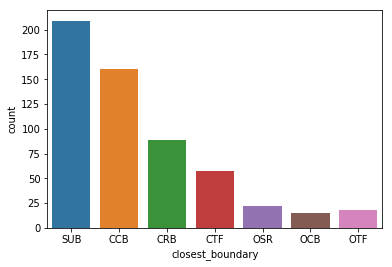

In [8]:
sns.countplot(boundary_distances["closest_boundary"])

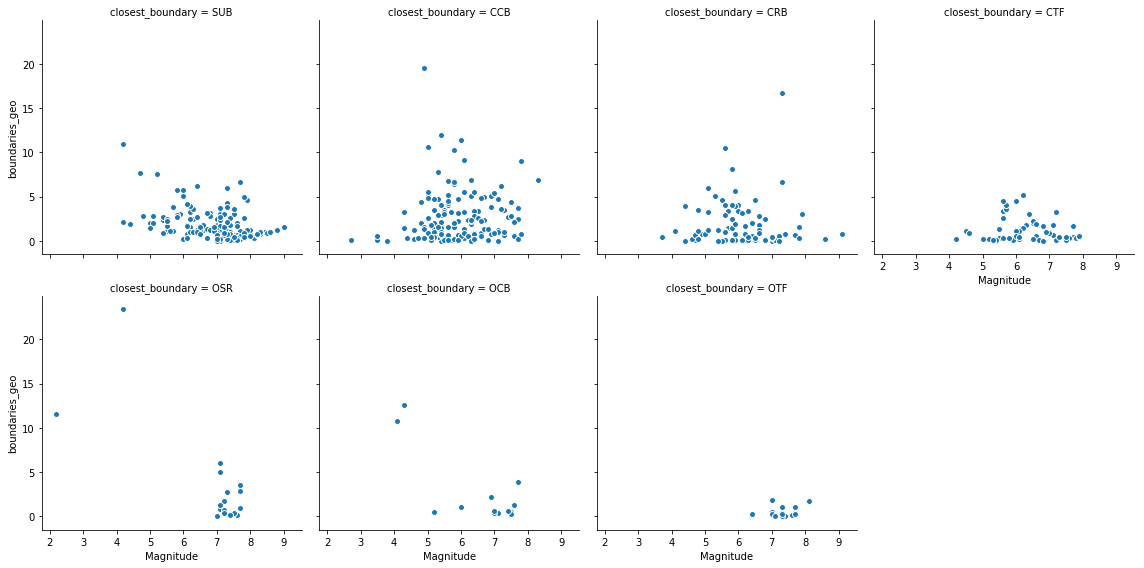

In [9]:
#plt.scatter(x=boundary_distances["Magnitude"], y=boundary_distances["boundaries_geo"])
#plt.scatter(x=boundary_distances["Magnitude"], y=boundary_distances["sub_geo"])
g = sns.FacetGrid(boundary_distances,  col = "closest_boundary", col_wrap=4, size = 4)
g = g.map(plt.scatter, "Magnitude", "boundaries_geo", edgecolor="w")

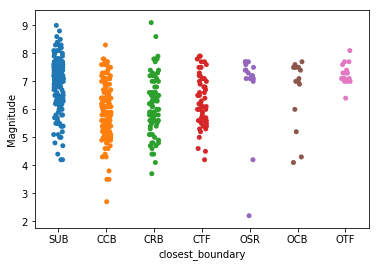

In [10]:
sns.stripplot(x="closest_boundary", y="Magnitude", data=boundary_distances, jitter=True)

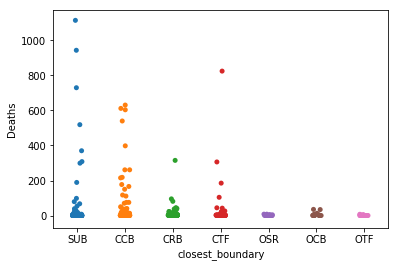

In [11]:
sns.stripplot(x="closest_boundary", y="Deaths", data=boundary_distances, jitter=True)

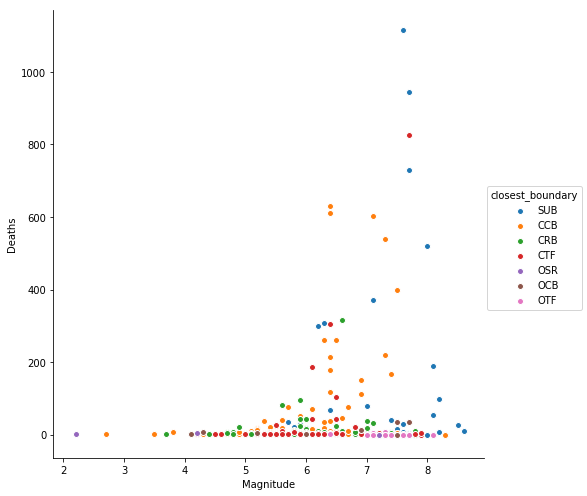

In [12]:
g2 = sns.FacetGrid(boundary_distances,  hue="closest_boundary", size = 7)
g2 = g2.map(plt.scatter, "Magnitude", "Deaths", edgecolor="w").add_legend()

In [44]:
earthquakes2_geo = earthquakes2_gdf["geometry"]
len(earthquakes2_geo)
#earthquakes2_gdf

24638

def closest_boundary2(geoseries):
    min_distances = []
    
    for i, point in enumerate(earthquakes2_geo):
        min_dist = np.min([point.distance(line) for line in geoseries])
        min_distances.append(min_dist)
    return min_distances

dict_list = [boundaries_geo, sub_geo, ccb_geo, crb_geo, ctf_geo, ocb_geo, osr_geo, otf_geo]

total_min_distances2 = []

for geoseries in dict_list:
    min_distances = closest_boundary2(geoseries)
    total_min_distances2.append(min_distances)
    
total_min_distances2

In [48]:
boundary_distances2 = pd.DataFrame(total_min_distances2)
boundary_distances2 = boundary_distances2.transpose()
boundary_distances2

,0,1,2,3,4,5,6,7
0,0.221410,22.051172,32.701335,30.812117,26.219884,27.611902,0.355460,0.221410
1,14.366975,30.915059,14.366975,18.764151,14.530203,27.458720,32.675968,27.458720
2,0.346336,24.585383,18.971821,0.346336,1.259295,14.433952,1.221475,2.743895
3,0.259956,2.108272,8.276883,1.254022,0.259956,4.269910,0.487571,0.855725
4,0.054731,2.327099,8.166058,1.221409,0.054731,4.319760,0.492587,0.732100
5,0.411938,0.411938,7.314302,7.007927,4.894661,2.280326,2.280326,1.489146
6,0.449286,0.449286,7.117457,6.870418,4.887415,2.088277,2.088277,1.307664
7,0.355971,0.355971,7.477691,7.141388,4.932414,2.433977,2.433977,1.632865
8,0.457863,4.427331,0.874442,2.031042,0.457863,3.708297,3.145046,6.147865
9,0.300413,2.574879,1.807350,1.467501,1.012547,0.300413,2.473092,0.300413


In [76]:
#boundary_distances2.columns = ["boundaries_geo2", "sub_geo2", "ccb_geo2", "crb_geo2", "ctf_geo2", "ocb_geo2", 
#                               "osr_geo2", "otf_geo2"]
earthquakes_dist2 = pd.concat([earthquakes2_gdf, boundary_distances2], axis=1)
#print(len(earthquakes_dist2))
#boundary_distances
#print(len(earthquakes2_gdf))
#earthquakes_dist.to_csv("MR_Data/Earthquake_boundary_distances")
#boundary_distances2
#earthquakes_dist2
earthquakes_dist2.to_csv("MR_Data/Earthquake_boundary_distances2")

AttributeError: module 'geopandas' has no attribute 'concat'

In [59]:
boundary_distances2 = pd.read_csv("MR_Data/Earthquake_boundary_distances2")
boundary_distances2 = boundary_distances2.drop("Unnamed: 0", axis = 1)

In [60]:
boundary_distances2

,date,depth,mag,id,place,geometry,boundaries_geo2,sub_geo2,ccb_geo2,crb_geo2,ctf_geo2,ocb_geo2,osr_geo2,otf_geo2
0,19600102,15.00,6.3,iscgem877909,Bouvet Island region,POINT (-1.89 -55.877),0.221410,22.051172,32.701335,30.812117,26.219884,27.611902,0.355460,0.221410
1,19600103,15.00,5.7,iscgem877920,"northern Xinjiang, China",POINT (84.542 43.7),14.366975,30.915059,14.366975,18.764151,14.530203,27.458720,32.675968,27.458720
2,19600104,15.00,6.1,iscgemsup877930,Djibouti,POINT (42.609 11.374),0.346336,24.585383,18.971821,0.346336,1.259295,14.433952,1.221475,2.743895
3,19600107,55.00,5.5,iscgem877960,"Nicobar Islands, India region",POINT (94.547 6.352),0.259956,2.108272,8.276883,1.254022,0.259956,4.269910,0.487571,0.855725
4,19600107,15.00,5.6,iscgem877954,"Nicobar Islands, India region",POINT (94.756 6.418),0.054731,2.327099,8.166058,1.221409,0.054731,4.319760,0.492587,0.732100
5,19600107,35.00,6.2,iscgem877956,South Sandwich Islands region,POINT (-27.278 -55.591),0.411938,0.411938,7.314302,7.007927,4.894661,2.280326,2.280326,1.489146
6,19600108,35.00,6.0,iscgem877967,South Sandwich Islands region,POINT (-27.475 -55.585),0.449286,0.449286,7.117457,6.870418,4.887415,2.088277,2.088277,1.307664
7,19600108,15.00,5.9,iscgem877965,South Sandwich Islands region,POINT (-27.115 -55.57),0.355971,0.355971,7.477691,7.141388,4.932414,2.433977,2.433977,1.632865
8,19600111,15.00,5.6,iscgem877983,near the south coast of Myanmar,POINT (95.83199999999999 16.046),0.457863,4.427331,0.874442,2.031042,0.457863,3.708297,3.145046,6.147865
9,19600112,10.00,5.8,iscgem877990,Taiwan region,POINT (122.323 23.401),0.300413,2.574879,1.807350,1.467501,1.012547,0.300413,2.473092,0.300413


In [63]:
conditions = [
    (boundary_distances2['boundaries_geo2'] == boundary_distances2['sub_geo2']), 
    (boundary_distances2['boundaries_geo2'] == boundary_distances2['ccb_geo2']),
    (boundary_distances2['boundaries_geo2'] == boundary_distances2['crb_geo2']), 
    (boundary_distances2['boundaries_geo2'] == boundary_distances2['ctf_geo2']),
    (boundary_distances2['boundaries_geo2'] == boundary_distances2['ocb_geo2']), 
    (boundary_distances2['boundaries_geo2'] == boundary_distances2['osr_geo2']), 
    (boundary_distances2['boundaries_geo2'] == boundary_distances2['otf_geo2'])]
choices = ['SUB', 'CCB', 'CRB', 'CTF', 'OCB', 'OSR', 'OTF']
boundary_distances2['closest_boundary2'] = np.select(conditions, choices, default=np.nan)

In [64]:
boundary_distances2.head()

,date,depth,mag,id,place,geometry,boundaries_geo2,sub_geo2,ccb_geo2,crb_geo2,ctf_geo2,ocb_geo2,osr_geo2,otf_geo2,closest_boundary2
0,19600102,15.0,6.3,iscgem877909,Bouvet Island region,POINT (-1.89 -55.877),0.221410,22.051172,32.701335,30.812117,26.219884,27.611902,0.355460,0.221410,OTF
1,19600103,15.0,5.7,iscgem877920,"northern Xinjiang, China",POINT (84.542 43.7),14.366975,30.915059,14.366975,18.764151,14.530203,27.458720,32.675968,27.458720,CCB
2,19600104,15.0,6.1,iscgemsup877930,Djibouti,POINT (42.609 11.374),0.346336,24.585383,18.971821,0.346336,1.259295,14.433952,1.221475,2.743895,CRB
3,19600107,55.0,5.5,iscgem877960,"Nicobar Islands, India region",POINT (94.547 6.352),0.259956,2.108272,8.276883,1.254022,0.259956,4.269910,0.487571,0.855725,CTF
4,19600107,15.0,5.6,iscgem877954,"Nicobar Islands, India region",POINT (94.756 6.418),0.054731,2.327099,8.166058,1.221409,0.054731,4.319760,0.492587,0.732100,CTF


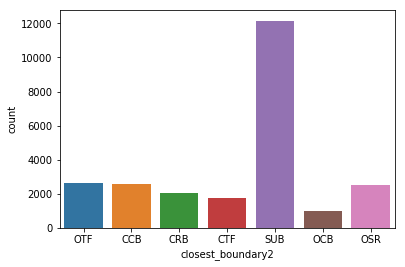

In [65]:
sns.countplot(boundary_distances2["closest_boundary2"])

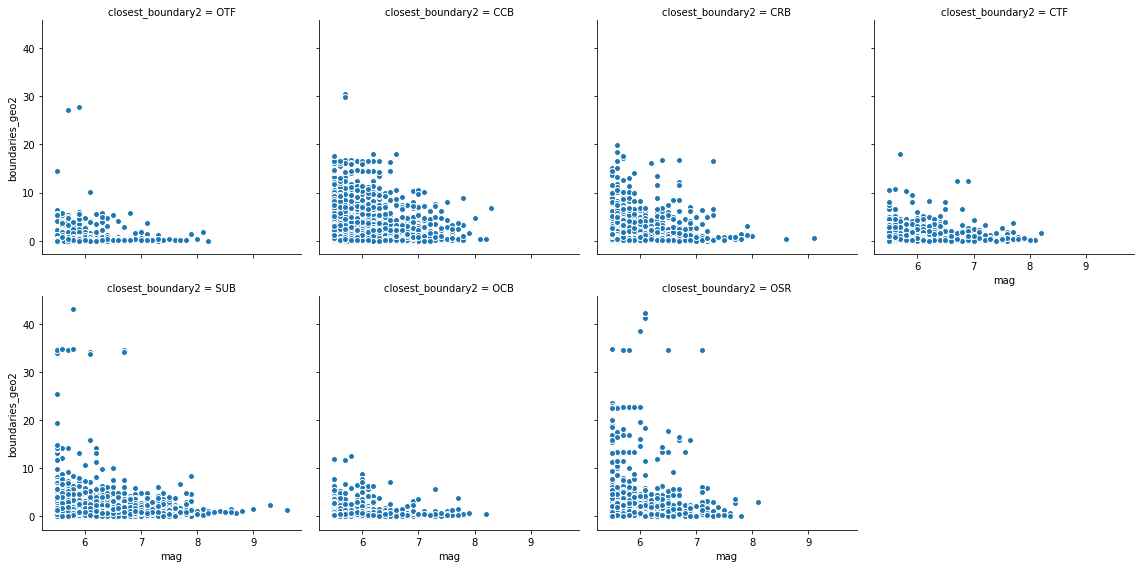

In [66]:
g = sns.FacetGrid(boundary_distances2,  col = "closest_boundary2", col_wrap=4, size = 4)
g = g.map(plt.scatter, "mag", "boundaries_geo2", edgecolor="w")

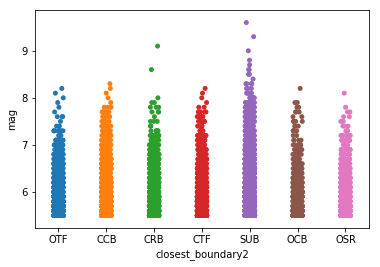

In [67]:
sns.stripplot(x="closest_boundary2", y="mag", data=boundary_distances2, jitter=True)

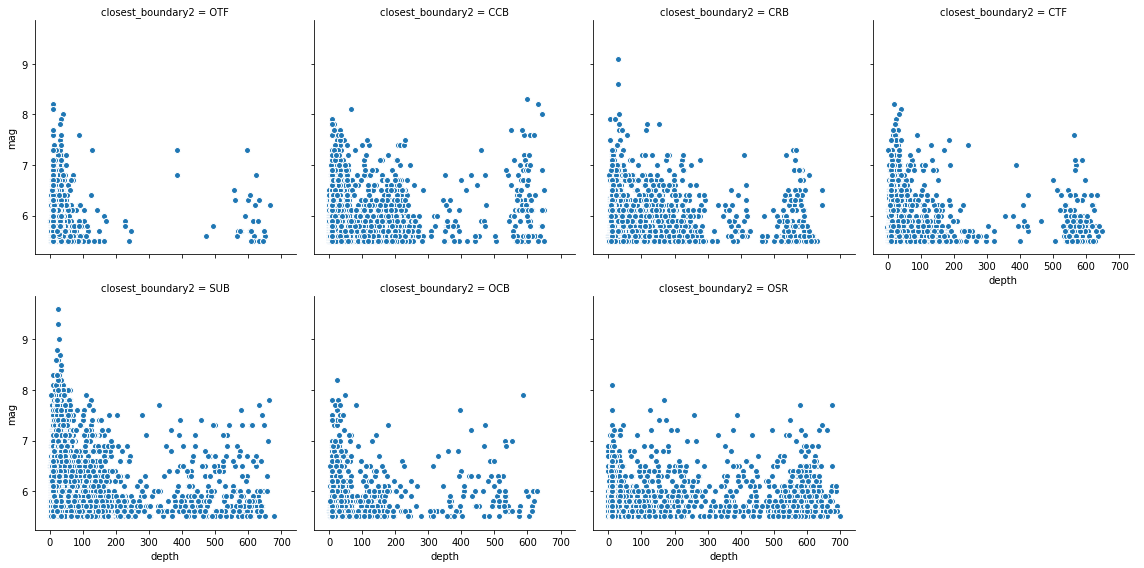

In [70]:
#g2 = sns.FacetGrid(boundary_distances2,  hue="closest_boundary2", size = 7)
#g2 = g2.map(plt.scatter, "depth", "mag", edgecolor="w").add_legend()
g2 = sns.FacetGrid(boundary_distances2,  col = "closest_boundary2", col_wrap=4, size = 4)
g2 = g2.map(plt.scatter, "depth", "mag", edgecolor="w")

min_dist = np.empty(len(earthquakes_gdf))
for i, point in enumerate(earthquakes_geo):
    min_dist[i] = np.min([point.distance(line) for line in sub_geo])
earthquakes_gdf['min_dist_to_lines_sub'] = min_dist
#earthquakes_gdf

In [13]:
boundary_sub = boundary_distances[boundary_distances["closest_boundary"]=="SUB"]
#boundary_sub.head()
#type(boundary_sub)
boundary_sub_gdf = gpd.GeoDataFrame(boundary_sub, crs = {'init': 'epsg:4326'})
#type(boundary_sub_gdf)
#type(boundary_sub_gdf.geometry)
#boundary_sub_gdf.crs

pandas.core.series.Series

In [15]:
plates_gdf.crs

{'init': 'epsg:4326'}

In [16]:
volcanoes_gdf.head()

,Name,Country,Type,lat,lng,Elevation,geometry
0,Abu,Japan,Shield,34.50,131.60,641.0,POINT (131.6 34.5)
1,Acamarachi,Chile,Stratovolcano,-23.30,-67.62,6046.0,POINT (-67.62 -23.3)
2,Acatenango,Guatemala,Stratovolcano,14.50,-90.88,3976.0,POINT (-90.88 14.5)
3,Acigöl-Nevsehir,Turkey,Caldera,38.57,34.52,1689.0,POINT (34.52 38.57)
4,Adams,USA,Stratovolcano,46.21,-121.49,3742.0,POINT (-121.49 46.21)


In [17]:
#volcanoes_gdf = volcanoes_gdf.drop([86, 96, 263, 276])
#volcanoes_gdf["Type"].value_counts()
#volcanoes_gdf[volcanoes_gdf["Type"] == '']
#len(volcanoes_gdf)
volcanoes_gdf[volcanoes_gdf["geometry"].isnull()]

,Name,Country,Type,lat,lng,Elevation,geometry
86,Columbia River Flood Basalts,USA,Flood Basalt,NaN,NaN,NaN,None
96,Deccan Traps,India,Flood Basalt,NaN,NaN,NaN,None
263,Navajo Volcanic Field,United States,Volcanic Field,NaN,NaN,2740.0,None
276,Oahu,United States,Shield,NaN,NaN,1220.0,None


In [18]:
strato_vol = volcanoes_gdf[volcanoes_gdf["Type"].str.contains("Stratovolcano")].geometry
#strato_vol
caldera_vol = volcanoes_gdf[volcanoes_gdf["Type"].str.contains("Caldera")].geometry
shield_vol = volcanoes_gdf[volcanoes_gdf["Type"].str.contains("Shield")].geometry
complex_vol = volcanoes_gdf[volcanoes_gdf["Type"].str.contains("Complex Volcano")].geometry
submarine_vol = volcanoes_gdf[volcanoes_gdf["Type"].str.contains("Submarine")].geometry
vol_field_vol = volcanoes_gdf[volcanoes_gdf["Type"].str.contains("Volcanic Field")].geometry
cinder_vol = volcanoes_gdf[volcanoes_gdf["Type"].str.contains("Cinder Cone")].geometry
dome_vol = volcanoes_gdf[volcanoes_gdf["Type"].str.contains("Dome")].geometry
fissure_vents_vol = volcanoes_gdf[volcanoes_gdf["Type"].str.contains("Fissure vents")].geometry
somma_vol = volcanoes_gdf[volcanoes_gdf["Type"].str.contains("Somma Volcano")].geometry
maar_vol = volcanoes_gdf[volcanoes_gdf["Type"].str.contains("Maar")].geometry
proclastic_vol = volcanoes_gdf[volcanoes_gdf["Type"].str.contains("Pyroclastic Cone")].geometry
flood_basalt_vol = volcanoes_gdf[volcanoes_gdf["Type"].str.contains("Flood Basalt")].geometry
tuff_vol = volcanoes_gdf[volcanoes_gdf["Type"].str.contains("Tuff Ring")].geometry
plug_vol = volcanoes_gdf[volcanoes_gdf["Type"].str.contains("Plug")].geometry
noname_vol = volcanoes_gdf[volcanoes_gdf["Type"].str.contains("")].geometry
type(noname_vol)

geopandas.geoseries.GeoSeries

In [29]:
#earthquakes_gdf[earthquakes_gdf["geometry"].isnull()]
earthquakes_gdf = earthquakes_gdf.drop(earthquakes_gdf[earthquakes_gdf["geometry"].isnull()].index)
earthquakes_geo = earthquakes_gdf["geometry"]

In [30]:
def closest_volcano(geoseries): 
    min_distances = []

    for i, point in enumerate(earthquakes_geo):
        min_dist = np.min([point.distance(vol) for vol in geoseries])
        min_distances.append(min_dist)
    return min_distances

In [31]:
vol_type_list = [strato_vol, caldera_vol, shield_vol, complex_vol, submarine_vol, vol_field_vol, cinder_vol, 
                 dome_vol, fissure_vents_vol, somma_vol, maar_vol, proclastic_vol, flood_basalt_vol, tuff_vol, 
                 plug_vol]#, noname_vol]

total_min_distances = []

for geoseries in vol_type_list: 
    min_distances = closest_volcano(geoseries) 
    total_min_distances.append(min_distances)

total_min_distances

ValueError: Null geometry supports no operations

In [ ]:
distance_test = [quake.distance(strato_vol) for quake in earthquakes_geo]

In [26]:
earthquakes_geo[earthquakes_geo.isnull()]

269    None
292    None
293    None
323    None
324    None
347    None
348    None
361    None
368    None
380    None
398    None
411    None
412    None
Name: geometry, dtype: object

In [74]:
type(earthquakes_gdf)

geopandas.geodataframe.GeoDataFrame

In [75]:
type(earthquakes2_gdf)

geopandas.geodataframe.GeoDataFrame

In [84]:
earthquakes_dist2_test = earthquakes2_gdf.merge(boundary_distances2, left_index = True, right_index = True)

In [85]:
type(earthquakes_dist2_test)

pandas.core.frame.DataFrame

In [86]:
earthquakes_dist2_test = gpd.GeoDataFrame(boundary_distances2, crs = {'init': 'epsg:4326'}, geometry = earthquakes2_gdf.geometry)

In [88]:
type(earthquakes_dist2_test)

geopandas.geodataframe.GeoDataFrame

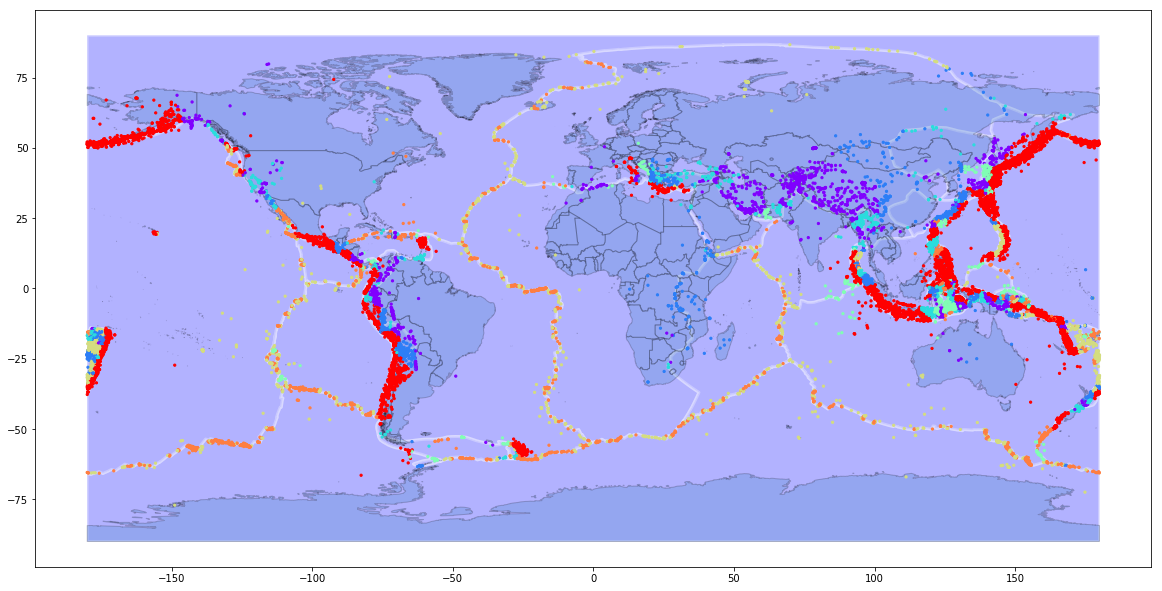

In [98]:
fig, ax = plt.subplots(figsize = (20, 20))
ax.set_aspect('equal')
plates_gdf.plot(ax=ax, color='blue', edgecolor='white', alpha = 0.3, lw = 3.0)
countries_gdf.plot(ax=ax, edgecolor='black', alpha = 0.2)
#boundaries_gdf.plot(ax=ax, column = "STEPCLASS", cmap = "rainbow", lw = 3, legend = True)
earthquakes_dist2_test.plot(ax=ax, markersize = 5, column = "closest_boundary2", cmap = "rainbow")

(array([  2.15190000e+04,   1.95400000e+03,   5.61000000e+02,
          1.98000000e+02,   9.60000000e+01,   5.50000000e+01,
          6.30000000e+01,   1.15000000e+02,   1.50000000e+01,
          3.00000000e+00,   3.10000000e+01,   1.00000000e+00,
          2.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          7.00000000e+00,   1.20000000e+01,   1.00000000e+00,
          0.00000000e+00,   3.00000000e+00]),
 array([  1.60635699e-05,   2.15715126e+00,   4.31428646e+00,
          6.47142165e+00,   8.62855685e+00,   1.07856920e+01,
          1.29428272e+01,   1.50999624e+01,   1.72570976e+01,
          1.94142328e+01,   2.15713680e+01,   2.37285032e+01,
          2.58856384e+01,   2.80427736e+01,   3.01999088e+01,
          3.23570440e+01,   3.45141792e+01,   3.66713144e+01,
          3.88284496e+01,   4.09855848e+01,   4.31427200e+01]),
 <a list of 20 Patch objects>)

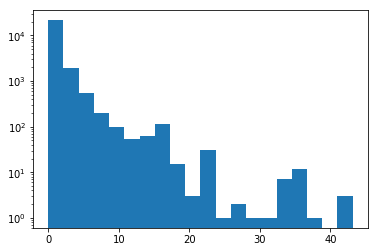

In [96]:
plt.yscale('log', nonposy='clip')
plt.hist(boundary_distances2["boundaries_geo2"], bins = 20)